In [42]:
# import pickle
# with open('FakeNewsDetectionPickle.pkl') as file:
#     all_words,auc1,auc2,auc3,auc4,classifier1,classifier2,classifier3,classifiers,clf,cm,data,dct,DTmodel,DTprediction,EnsPrediction,fake,fake_data,fpr1,fpr2,fpr3,fpr4,LRmodel,LRprediction,NB_classifier,NBmodel,NBprediction,pipe,real_data,RFmodel,RFprediction,stop,stopwords,SVMmodel,SVMprediction,thresholds1,thresholds2,thresholds3,thresholds4,token_space,tpr1,tpr2,tpr3,tpr4,true,vector_size,voting_classifier,word2vec_model,wordcloud,X_test,X_test_w2v,X_train,X_train_w2v,y_prob_DT,y_prob_LR,y_prob_NB,y_prob_RF,y_test,y_train = pickle.load(file)

# Fake news detection using ML 

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [44]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [45]:
fake.shape

(23481, 4)

In [46]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [47]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [48]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [49]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [50]:
# Check the data
data.head()

,title,text,subject,date,target
0,FOX NEWS Chooses Muslim “Victim” To Question G...,Islamic terrorism is the #1 issue with most Am...,politics,"Jan 28, 2016",fake
1,"NFL policy on anthem kneeling unchanged, despi...",NEW YORK (Reuters) - National Football League ...,politicsNews,"October 17, 2017",true
2,FIREWORKS! THE VIEW’S CONSERVATIVE PANELIST Ge...,,politics,"Mar 14, 2017",fake
3,BREAKING: VIOLENCE ERUPTS (AGAIN) IN FERGUSON…...,FERGUSON PART II: Police are having a difficu...,left-news,"Apr 29, 2015",fake
4,33-Yr Old Skier LINDSEY VONN Says She Won’t Re...,"Has there ever been a US Olympic athlete who, ...",politics,"Dec 7, 2017",fake


In [51]:
# Removing the date
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,FOX NEWS Chooses Muslim “Victim” To Question G...,Islamic terrorism is the #1 issue with most Am...,politics,fake
1,"NFL policy on anthem kneeling unchanged, despi...",NEW YORK (Reuters) - National Football League ...,politicsNews,true
2,FIREWORKS! THE VIEW’S CONSERVATIVE PANELIST Ge...,,politics,fake
3,BREAKING: VIOLENCE ERUPTS (AGAIN) IN FERGUSON…...,FERGUSON PART II: Police are having a difficu...,left-news,fake
4,33-Yr Old Skier LINDSEY VONN Says She Won’t Re...,"Has there ever been a US Olympic athlete who, ...",politics,fake


In [52]:
# Removing the title
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,Islamic terrorism is the #1 issue with most Am...,politics,fake
1,NEW YORK (Reuters) - National Football League ...,politicsNews,true
2,,politics,fake
3,FERGUSON PART II: Police are having a difficu...,left-news,fake
4,"Has there ever been a US Olympic athlete who, ...",politics,fake


In [53]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,islamic terrorism is the #1 issue with most am...,politics,fake
1,new york (reuters) - national football league ...,politicsNews,true
2,,politics,fake
3,ferguson part ii: police are having a difficu...,left-news,fake
4,"has there ever been a us olympic athlete who, ...",politics,fake


In [54]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [55]:
# Check
data.head()

,text,subject,target
0,islamic terrorism is the 1 issue with most ame...,politics,fake
1,new york reuters national football league off...,politicsNews,true
2,,politics,fake
3,ferguson part ii police are having a difficul...,left-news,fake
4,has there ever been a us olympic athlete who b...,politics,fake


In [56]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sidum\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
data.head()

,text,subject,target
0,islamic terrorism 1 issue americans would fox ...,politics,fake
1,new york reuters national football league offi...,politicsNews,true
2,,politics,fake
3,ferguson part ii police difficult time investi...,left-news,fake
4,ever us olympic athlete representing united st...,politics,fake


In [58]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')

def lemmatize_text(text):
  lemmatizer = WordNetLemmatizer()
  words = text.split()
  lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
  return ' '.join(lemmatized_words)

data['text'] = data['text'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sidum\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


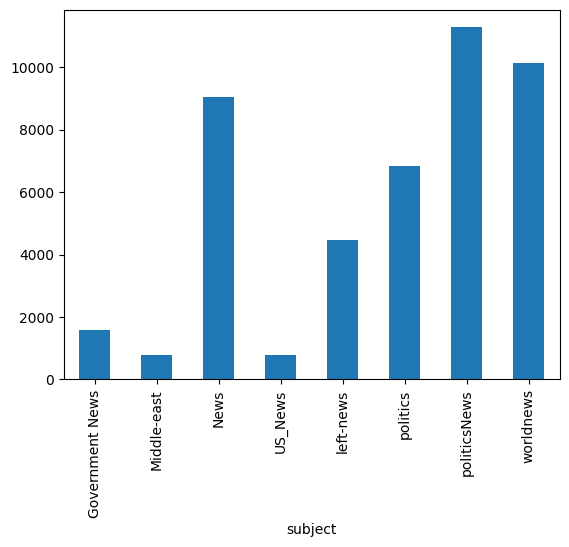

In [59]:
# How many articles per subject
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


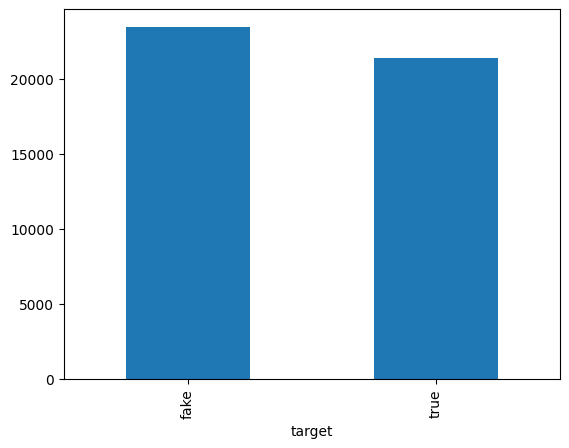

In [60]:
# How many fake and real articles
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

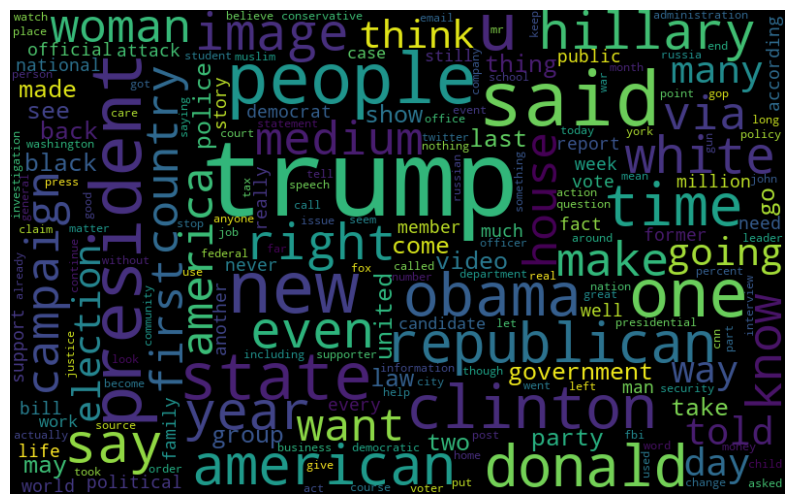

In [61]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

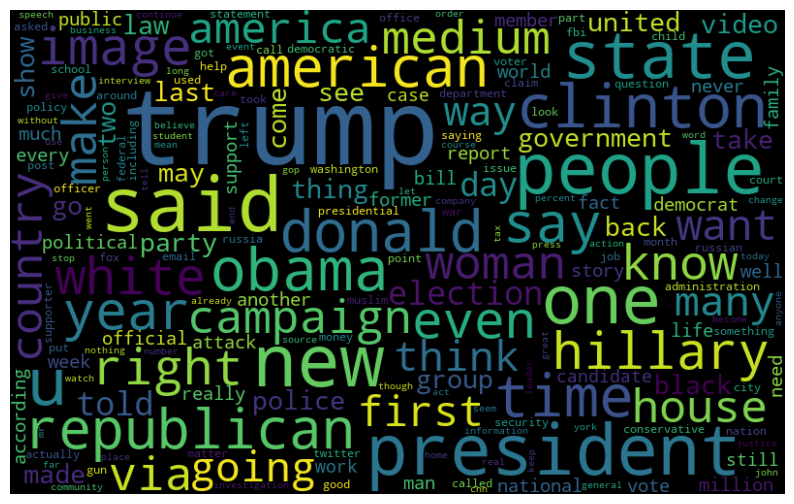

In [62]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [63]:
# Most frequent words counter (ref: https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

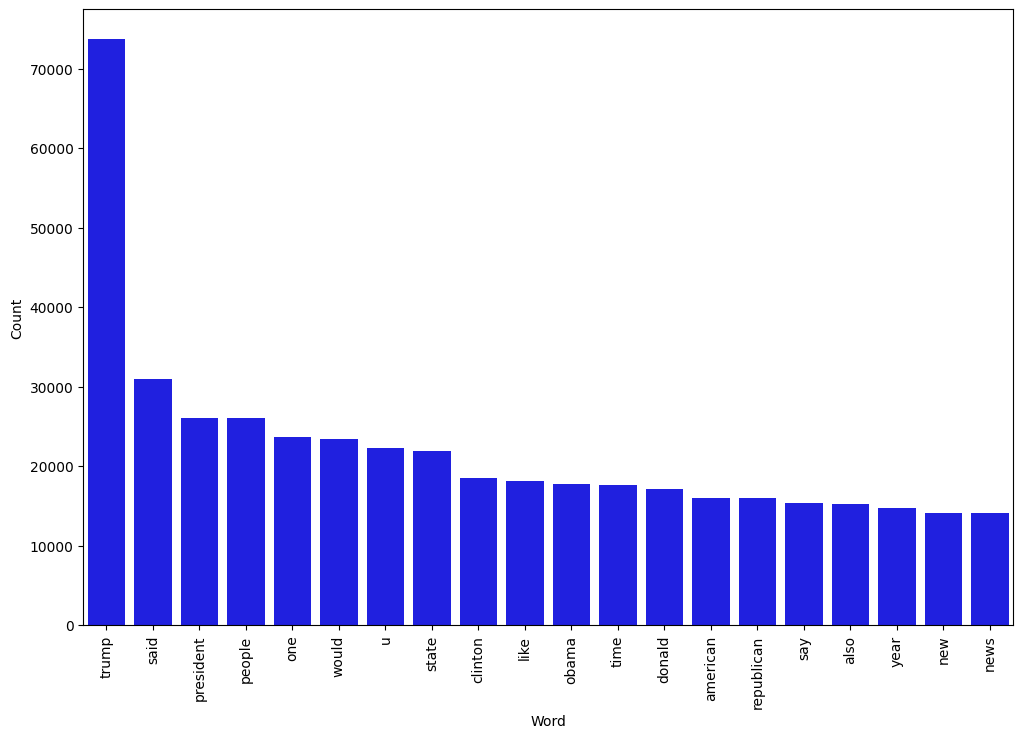

In [64]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

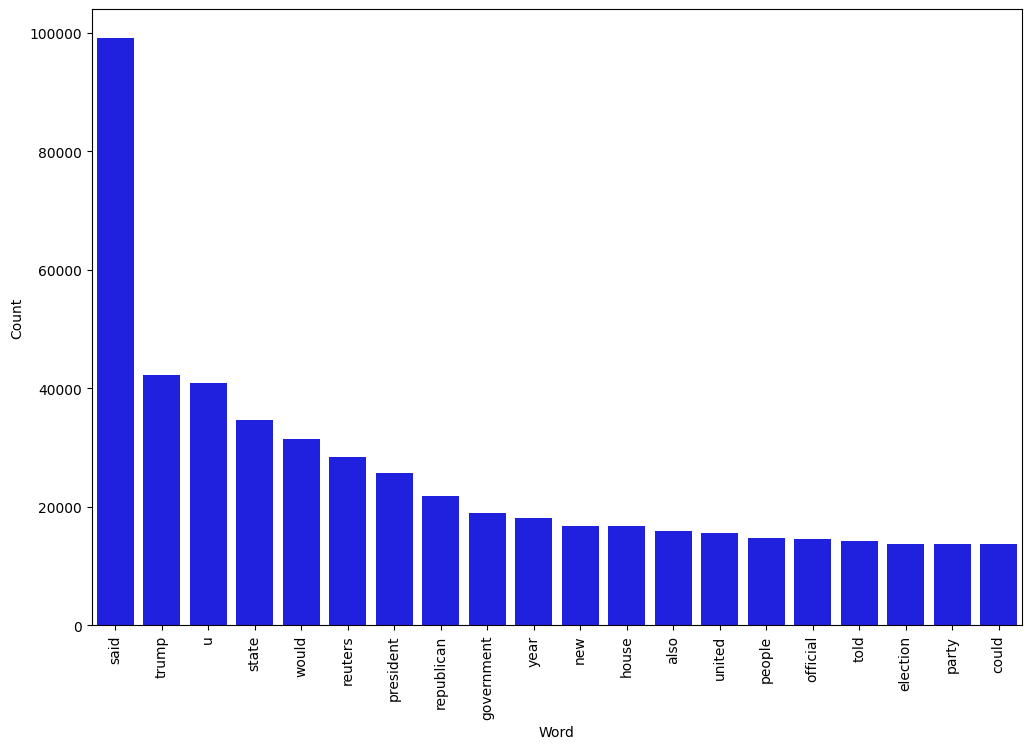

In [65]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [66]:
# Function to plot the confusion matrix (ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [67]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# **Naive Bayes**




In [68]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

NBmodel = pipe.fit(X_train, y_train)
NBprediction = NBmodel.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, NBprediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, NBprediction)*100,2)

accuracy: 95.57%


Confusion matrix, without normalization


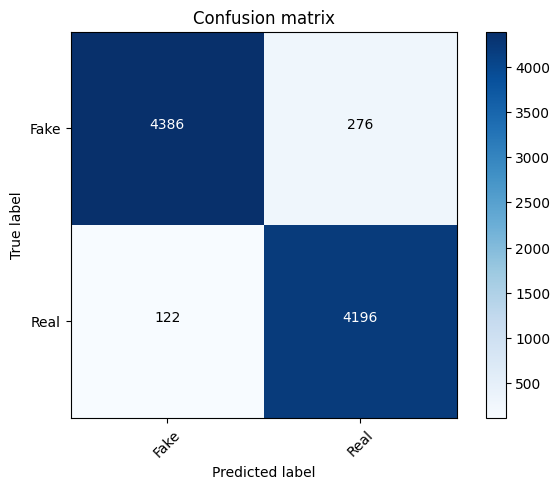

In [69]:
cm = metrics.confusion_matrix(y_test, NBprediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Logistic regression**

In [70]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
LRmodel = pipe.fit(X_train, y_train)

# Accuracy
LRprediction = LRmodel.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, LRprediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, LRprediction)*100,2)


accuracy: 99.0%


Confusion matrix, without normalization


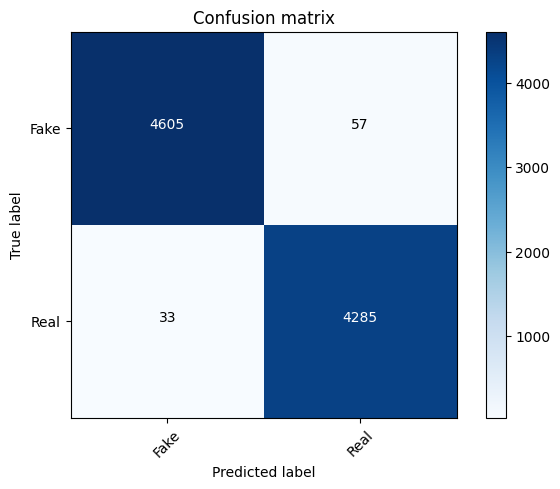

In [71]:
cm = metrics.confusion_matrix(y_test, LRprediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Decision Tree**

In [72]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
DTmodel = pipe.fit(X_train, y_train)

# Accuracy
DTprediction = DTmodel.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, DTprediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, DTprediction)*100,2)

accuracy: 99.67%


Confusion matrix, without normalization


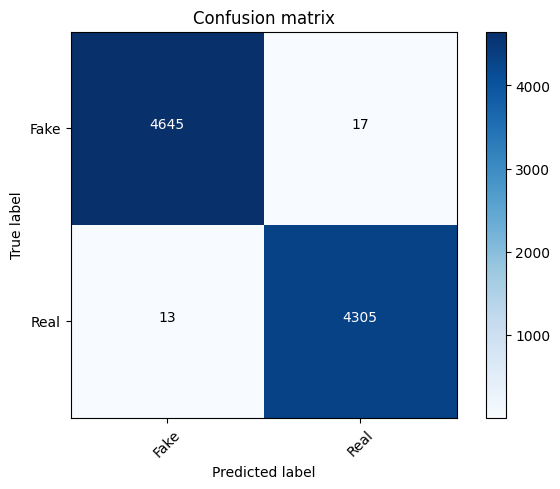

In [73]:
cm = metrics.confusion_matrix(y_test, DTprediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Random Forest**

In [74]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

RFmodel = pipe.fit(X_train, y_train)
RFprediction = RFmodel.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, RFprediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, RFprediction)*100,2)


accuracy: 99.08%


Confusion matrix, without normalization


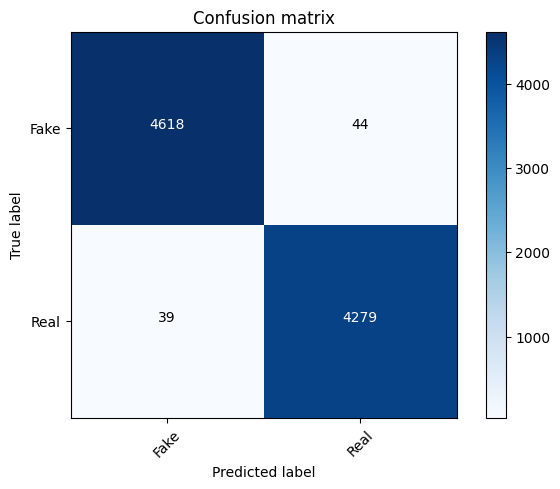

In [75]:
cm = metrics.confusion_matrix(y_test, RFprediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **SVM**

In [76]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel = 'linear', probability = True)

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

SVMmodel = pipe.fit(X_train, y_train)
SVMprediction = SVMmodel.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, SVMprediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, SVMprediction)*100,2)



accuracy: 99.64%


Confusion matrix, without normalization


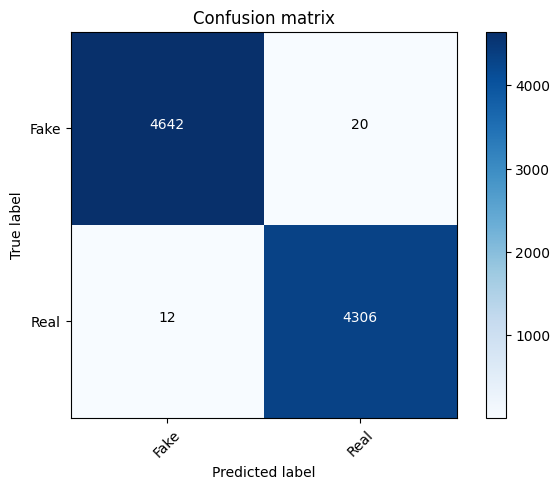

In [77]:
cm = metrics.confusion_matrix(y_test, SVMprediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Comparing** **Different Models**

([<matplotlib.axis.YTick at 0x1dca75d84d0>,
 [Text(0, 91, '91'),
  Text(0, 92, '92'),
  Text(0, 93, '93'),
  Text(0, 94, '94'),
  Text(0, 95, '95'),
  Text(0, 96, '96'),
  Text(0, 97, '97'),
  Text(0, 98, '98'),
  Text(0, 99, '99'),
  Text(0, 100, '100')])

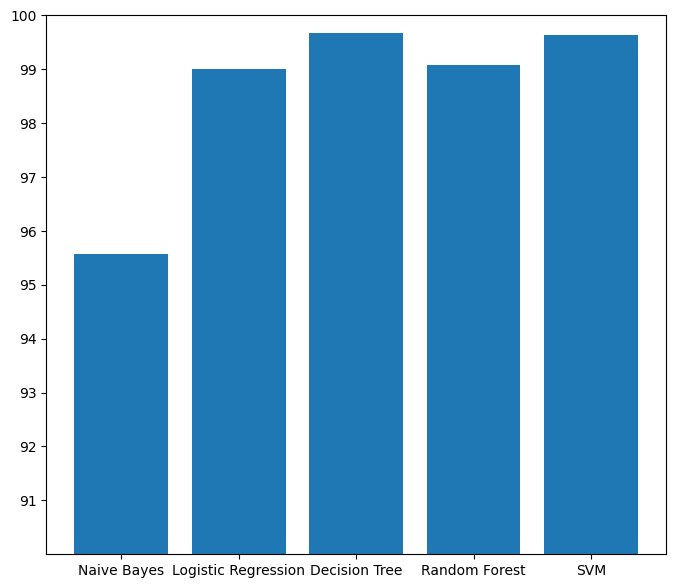

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

In [79]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [1]:
# word 2 vec try
from gensim.models import Word2Vec
import gensim.downloader as api

# Download a pre-trained Word2Vec model (e.g., 'glove-wiki-gigaword-100')
word2vec_model = api.load("glove-wiki-gigaword-100")

classifier1 = DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42)

classifier2 = RandomForestClassifier()

classifier3 = SVC(max_iter=100000, probability = True)

classifiers = [
    ('DT',classifier1),
    ('RFC',classifier2),
    ('svc',classifier3)
]

def text_to_w2v_vector(text, model, vector_size):
    words = text.split()
    vector = np.zeros(vector_size)
    count = 0
    for word in words:
        if word in model:
            vector += model[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

vector_size = 100
X_train_w2v = [text_to_w2v_vector(text, word2vec_model, vector_size) for text in X_train]
X_test_w2v = [text_to_w2v_vector(text, word2vec_model, vector_size) for text in X_test]

voting_classifier = VotingClassifier(estimators=classifiers, voting='soft')

# Fit the VotingClassifier to the training data
voting_classifier.fit(X_train_w2v, y_train)

# Make predictions on the test data
EnsPrediction = voting_classifier.predict(X_test_w2v)
print("accuracy: {}%".format(round(accuracy_score(y_test, EnsPrediction)*100,2)))
dct['Ensemble'] = round(accuracy_score(y_test, EnsPrediction)*100,2)

accuracy: 99.65%


Confusion matrix, without normalization


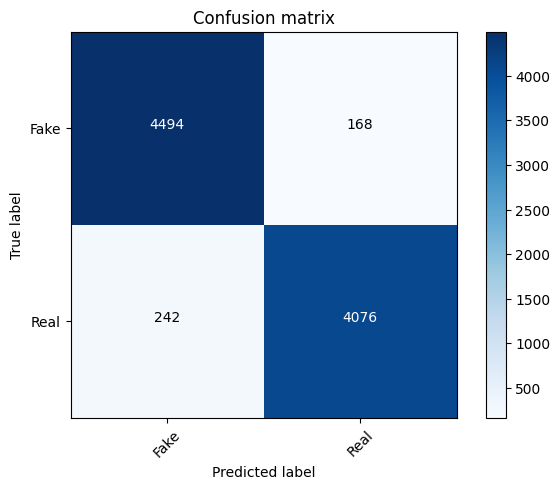

In [85]:
cm = metrics.confusion_matrix(y_test, EnsPrediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

$$
ROC AUC
$$

In [87]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob_NB = NBmodel.predict_proba(X_train)[:, 1]
y_prob_LR = LRmodel.predict_proba(X_train)[:, 1]
y_prob_DT = DTmodel.predict_proba(X_train)[:, 1]
y_prob_RF = RFmodel.predict_proba(X_train)[:, 1]
y_prob_SVM = SVMmodel.predict_proba(X_train)[:, 1]
y_prob_ENS = voting_classifier.predict_proba(X_train_w2v)[:, 1]

fpr1, tpr1, thresholds1 = roc_curve(y_train, y_prob_NB, pos_label='true')
fpr2, tpr2, thresholds2 = roc_curve(y_train, y_prob_LR, pos_label='true')
fpr3, tpr3, thresholds3 = roc_curve(y_train, y_prob_DT, pos_label='true')
fpr4, tpr4, thresholds4 = roc_curve(y_train, y_prob_RF, pos_label='true')
fpr5, tpr5, thresholds5 = roc_curve(y_train, y_prob_SVM, pos_label='true')
fpr6, tpr6, thresholds6 = roc_curve(y_train, y_prob_ENS, pos_label='true')

auc1 = roc_auc_score(y_train, y_prob_NB)
print(f'AUC of NB model: {auc1:.2f}')
auc2 = roc_auc_score(y_train, y_prob_LR)
print(f'AUC of LR model: {auc2:.2f}')
auc3 = roc_auc_score(y_train, y_prob_DT)
print(f'AUC of DT model: {auc3:.2f}')
auc4 = roc_auc_score(y_train, y_prob_RF)
print(f'AUC of RF model: {auc4:.2f}')
auc5 = roc_auc_score(y_train, y_prob_SVM)
print(f'AUC of SVM model: {auc5:.2f}')
auc6 = roc_auc_score(y_train, y_prob_ENS)
print(f'AUC of ENS model: {auc6:.2f}')

AUC of NB model: 0.99
AUC of LR model: 1.00
AUC of DT model: 1.00
AUC of RF model: 1.00
AUC of SVM model: 1.00
AUC of ENS model: 1.00


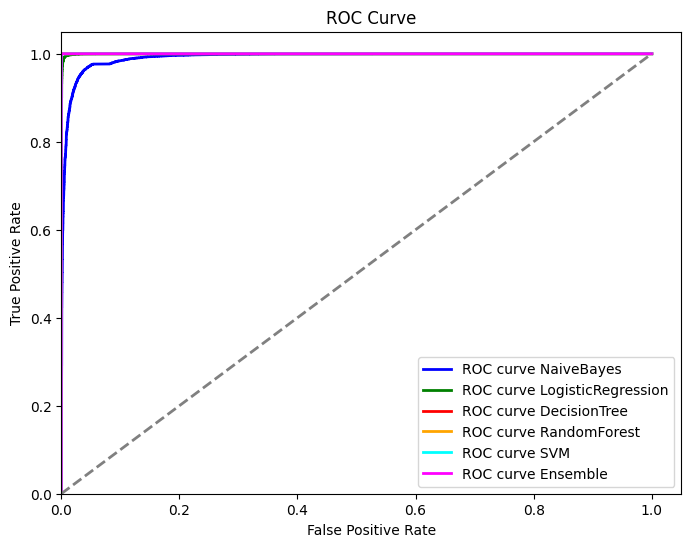

In [88]:
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='blue', lw=2, label='ROC curve NaiveBayes')
plt.plot(fpr2, tpr2, color='green', lw=2, label='ROC curve LogisticRegression')
plt.plot(fpr3, tpr3, color='red', lw=2, label='ROC curve DecisionTree')
plt.plot(fpr4, tpr4, color='orange', lw=2, label='ROC curve RandomForest')
plt.plot(fpr5, tpr5, color='cyan', lw=2, label='ROC curve SVM')
plt.plot(fpr6, tpr6, color='magenta', lw=2, label='ROC curve Ensemble')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# # storing the variables for quick reloading
# import pickle
# with open('FakeNewsDetectionPickle.pkl', 'wb') as file:
#     pickle.dump([all_words,auc1,auc2,auc3,auc4,classifier1,classifier2,classifier3,classifiers,clf,cm,data,dct,DTmodel,DTprediction,EnsPrediction,fake,fake_data,fpr1,fpr2,fpr3,fpr4,LRmodel,LRprediction,NB_classifier,NBmodel,NBprediction,pipe,real_data,RFmodel,RFprediction,stop,stopwords,SVMmodel,SVMprediction,thresholds1,thresholds2,thresholds3,thresholds4,token_space,tpr1,tpr2,tpr3,tpr4,true,vector_size,voting_classifier,word2vec_model,wordcloud,X_test,X_test_w2v,X_train,X_train_w2v,y_prob_DT,y_prob_LR,y_prob_NB,y_prob_RF,y_test,y_train], file)